# Wasserstein GAN

In [1]:
# pip install gdown

## Dataset

In [2]:
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets.celeba import CelebA
from torch.utils.data import DataLoader
from torchvision.utils import make_grid


transform = T.Compose(
    [
        T.Resize(64),
        T.CenterCrop(64),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
dataset = CelebA(
    "./datasets", download=True, transform=transform
)
loader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

Files already downloaded and verified


## Generator

In [3]:
import torch
import torch.nn as nn


class Generator(nn.Module):
    def __init__(self, num_channel=3, latent_dim=100, feature_dim=64):
        super().__init__()

        self.layer_1 = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, feature_dim * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_dim * 8),
            nn.ReLU(True),
        )
        self.layer_2 = nn.Sequential(
            nn.ConvTranspose2d(feature_dim * 8, feature_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_dim * 4),
            nn.ReLU(True),
        )
        self.layer_3 = nn.Sequential(
            nn.ConvTranspose2d(feature_dim * 4, feature_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_dim * 2),
            nn.ReLU(True),
        )
        self.layer_4 = nn.Sequential(
            nn.ConvTranspose2d(feature_dim * 2, feature_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_dim),
            nn.ReLU(True),
        )
        self.last_layer = nn.Sequential(
            nn.ConvTranspose2d(feature_dim, num_channel, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z):
        # decoding
        layer_1_out = self.layer_1(z)  # (N, 512, 4, 4)
        layer_2_out = self.layer_2(layer_1_out)  # (N, 256, 8, 8)
        layer_3_out = self.layer_3(layer_2_out)  # (N, 128, 16, 16)
        layer_4_out = self.layer_4(layer_3_out)  # (N, 64, 32, 32)
        # transform to rgb
        out = self.last_layer(layer_4_out)  # (N, 3, 64, 64)
        return out

## Discriminator

In [4]:
class Discriminator(nn.Module):
    def __init__(self, num_channel=3, feature_dim=64):
        super().__init__()
        self.layer_1 = nn.Sequential(
            nn.Conv2d(num_channel, feature_dim, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(feature_dim, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer_2 = nn.Sequential(
            nn.Conv2d(feature_dim, feature_dim * 2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(feature_dim * 2, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer_3 = nn.Sequential(
            nn.Conv2d(feature_dim * 2, feature_dim * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(feature_dim * 4, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer_4 = nn.Sequential(
            nn.Conv2d(feature_dim * 4, feature_dim * 8, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(feature_dim * 8, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.last_layer = nn.Sequential(
            nn.Conv2d(feature_dim * 8, 1, 4, 1, 0, bias=False)
        )

    def forward(self, x):
        # encoding
        layer_1_out = self.layer_1(x)  # (N, 64, 32, 32)
        layer_2_out = self.layer_2(layer_1_out)  # (N, 128, 16, 16)
        layer_3_out = self.layer_3(layer_2_out)  # (N, 256, 8, 8)
        layer_4_out = self.layer_4(layer_3_out)  # (N, 512, 4, 4)
        # classify
        out = self.last_layer(layer_4_out).squeeze()  # (N)
        return out


## Train

## Train

### Weight initialization

In [5]:
latent_dim = 100
generator = Generator(latent_dim=latent_dim)
discriminator = Discriminator()

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
_ = generator.apply(weights_init)
_ = discriminator.apply(weights_init)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
_ = discriminator.to(device)
_ = generator.to(device)

### Logger

In [10]:
from torch.utils.tensorboard import SummaryWriter

# tensorboard logger
writer = SummaryWriter()

### Optimizer

In [11]:
import torch.optim as optim

# optimizer
discriminator_opt = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.9))
generator_opt = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.9))

### Gradient penalty

In [12]:
def compute_gradient_penalty(disrciminator, real_data, fake_data):
    device = real_data.device
    alpha = torch.rand(real_data.size(0), 1).to(device)
    alpha = alpha.expand(real_data.size())

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates = interpolates.to(device)
    interpolates = torch.autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = disrciminator(interpolates)
    grad_outputs = torch.ones(disc_interpolates.size(), requires_grad=False).to(device)
    gradients = torch.autograd.grad(
        outputs=disc_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

### Code

In [13]:
from tqdm import tqdm


# for meta
n_epochs = 5
n_critic = 5
lambda_gp = 10

# for visualization
iteration = 0
fixed_z = torch.randn((64, latent_dim, 1, 1)).to(device)

# for iteration history
G_loss_history = []
D_loss_history = []


# train code
for epoch in range(n_epochs):
    epoch_G_loss = 0.0
    epoch_D_loss = 0.0

    for step, batch in enumerate(tqdm(loader, desc=f"Epoch {epoch + 1}/{n_epochs}")):
        step += 1
        generator.train()
        discriminator.train()

        x = batch[0].to(device)
        batch_size = x.size(0)

        #
        # 1. get discriminator loss from real data
        #
        discriminator_opt.zero_grad()
        real_D_score = discriminator(x)
        real_D_loss = real_D_score.mean()
        #
        # 2. get discriminator loss from fake data
        #
        z = torch.randn((batch_size, latent_dim, 1, 1)).to(device)
        fake_data = generator(z)
        fake_D_score = discriminator(fake_data)
        fake_D_loss = fake_D_score.mean()
        #
        # 3. get penalty
        #
        gradient_penalty = compute_gradient_penalty(discriminator, x, fake_data)
        #
        # 4. get discriminator loss and update discriminator
        #
        D_wasserstein_loss = -real_D_loss + fake_D_loss + lambda_gp * gradient_penalty
        D_wasserstein_loss.backward()
        discriminator_opt.step()

        # logging
        D_loss_history += [D_wasserstein_loss.item()]
        epoch_D_loss += D_wasserstein_loss.item() * len(x) / len(loader.dataset)
        writer.add_scalar("Loss/discriminator", D_wasserstein_loss, iteration)
        #
        # 5. get generator loss and update generator after n_critic
        #
        if step % n_critic == 0:
            generator_opt.zero_grad()
            z = torch.randn((batch_size, latent_dim, 1, 1)).to(device)
            generated_data = generator(z)
            generate_D_score = discriminator(generated_data)
            G_loss = -generate_D_score.mean()
            G_loss.backward()
            generator_opt.step()
            
            # logging
            G_loss_history += [G_loss.item()]
            epoch_G_loss += G_loss.item() * len(x) / len(loader.dataset) * n_critic
            writer.add_scalar("Loss/generator", G_loss, iteration)

        # iteration checkpoint
        if iteration % 2000 == 0:
            # visualization
            with torch.no_grad():
                generated_x = generator(fixed_z)
                generated_x = generated_x.detach().cpu()
                generated_x_grid = make_grid(generated_x, nrow=8).numpy()
                generated_x_grid = (generated_x_grid * 0.5) + 0.5
                generated_x_grid = np.transpose(generated_x_grid, (1, 2, 0))
                plt.imsave(f"wgan-gp-step-{iteration}.png", generated_x_grid)
            # model save
            torch.save(generator, f"wgan-gp-generator-step-{iteration}.pt")
        iteration += 1
    log_string = f"Loss at epoch {epoch + 1} - D_loss : {epoch_D_loss:.4f}, G_loss : {epoch_G_loss:.4f}"
    print(log_string)

# save last model
with torch.no_grad():
    generated_x = generator(fixed_z)
    generated_x = generated_x.detach().cpu()
    generated_x_grid = make_grid(generated_x, nrow=8).numpy()
    generated_x_grid = (generated_x_grid * 0.5) + 0.5
    generated_x_grid = np.transpose(generated_x_grid, (1, 2, 0))
    plt.imsave(f"wgan-gp-step-{iteration}.png", generated_x_grid)
torch.save(generator, f"wgan-gp-generator-step-{iteration}.pt")

Epoch 1/5: 100%|██████████| 2543/2543 [07:22<00:00,  5.75it/s]


Loss at epoch 1 - D_loss : -679.5134, G_loss : 385.6748


Epoch 2/5: 100%|██████████| 2543/2543 [03:53<00:00, 10.89it/s]


Loss at epoch 2 - D_loss : -3172.3561, G_loss : 1785.2840


Epoch 3/5: 100%|██████████| 2543/2543 [03:54<00:00, 10.85it/s]


Loss at epoch 3 - D_loss : -7107.0735, G_loss : 3821.5046


Epoch 4/5: 100%|██████████| 2543/2543 [03:52<00:00, 10.94it/s]


Loss at epoch 4 - D_loss : -11889.2962, G_loss : 6392.5631


Epoch 5/5: 100%|██████████| 2543/2543 [03:52<00:00, 10.93it/s]


Loss at epoch 5 - D_loss : -13613.4842, G_loss : 9169.3883


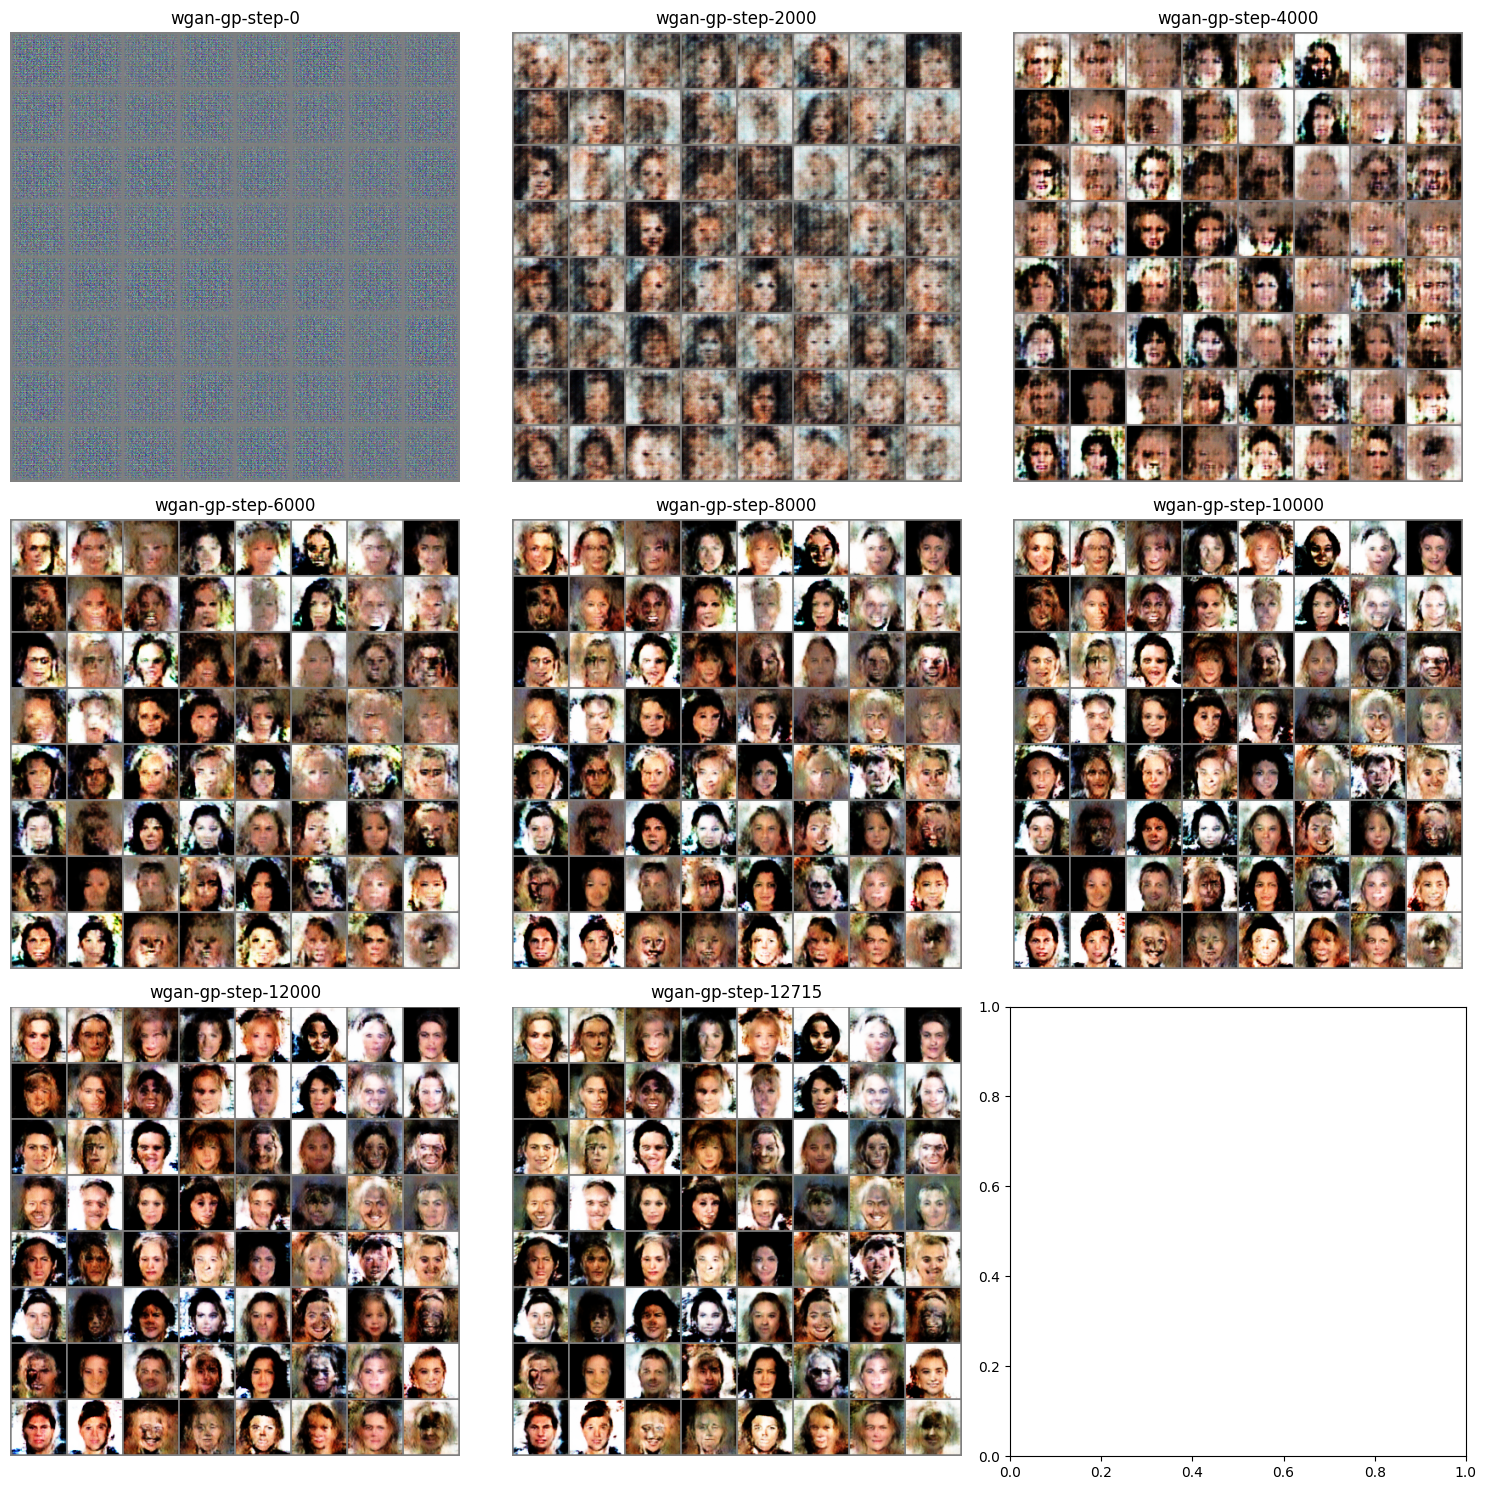

In [14]:
import os

img_list = list(sorted(filter(lambda x: x.startswith("wgan-gp-step"), os.listdir("."))))
step_filename = {}
for fname in filter(lambda x: x.startswith("wgan-gp-step"), os.listdir(".")):
    key = int(fname.replace("wgan-gp-step-", "").replace(".png", ""))
    step_filename[key] = fname

nrows = (len(img_list) // 3) + 1

fig, axes = plt.subplots(ncols=3, nrows=nrows, figsize=(5 * nrows, 15))
for idx, key in enumerate(sorted(step_filename)):
    fname = step_filename[key]
    array = plt.imread(fname)
    axes[idx // 3, idx % 3].imshow(array)
    axes[idx // 3, idx % 3].axis("off")
    axes[idx // 3, idx % 3].set_title(fname.replace(".png", ""))

plt.tight_layout()

### Generate

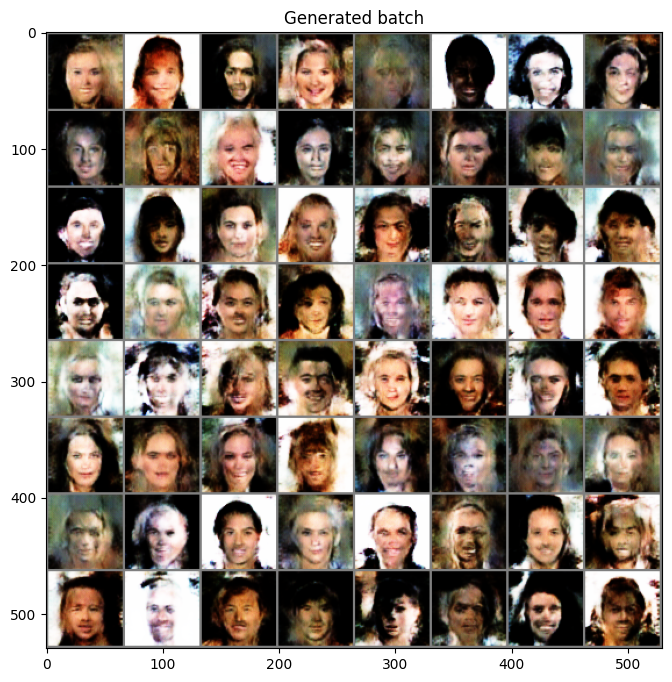

In [15]:
generator.eval()
with torch.no_grad():    
    random_z = torch.randn((64, latent_dim, 1, 1)).to(device)
    generated_x = generator(random_z)

generated_x_grid = make_grid(generated_x, nrow=8).cpu().numpy()
# make data range to 0~1
generated_x_grid = (generated_x_grid * 0.5) + 0.5
plt.figure(figsize=(8, 8))
plt.title("Generated batch")
plt.imshow(np.transpose(generated_x_grid, (1, 2, 0)))